In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os
%matplotlib inline  

# Download the 10x Dataset `1k PBMCs from a Healthy Donor (v3 chemistry)`

10x datasets are available at
https://support.10xgenomics.com/single-cell-gene-expression/datasets

The page for the `1k PBMCs from a Healthy Donor (v3 chemistry)` dataset is
https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3

But the FASTQ files (5.55GB) can be downloaded with `curl` directly (without giving them email info) from http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar

In the cell below we check if the dataset file `pbmc_1k_v3_fastqs.tar` already exists. If not we download the dataset to the same directory as this notebook


In [2]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('./pbmc_1k_v3_fastqs.tar')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar
else: print('Dataset already downloaded!')

Dataset already downloaded!


In [3]:
# now we untar the fastq files on neuron_1k_v3_fastqs folder
!tar -xvf ./pbmc_1k_v3_fastqs.tar

x pbmc_1k_v3_fastqs/
x pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
x pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz
x pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
x pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
x pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
x pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz


# Buiding the kallisto index

First make sure that kallisto is installed and the version is greater than 0.45

If it's not installed, see instructions at https://pachterlab.github.io/kallisto/download

In [4]:
!kallisto version 

kallisto, version 0.46.0


First we build the kallisto index for the dataset. 
The index is built from the published reference transcriptome for each organism.
Building the index takes a few minutes and needs to be done only once for each organism.

### Download reference transcriptome from ensembl
In order to do that we first download the human transcriptome from ensembl, you can see the reference genomes they have at https://uswest.ensembl.org/info/data/ftp/index.html

In [5]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('Homo_sapiens.GRCh38.cdna.all.fa.gz')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-97/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
else: print('Human transcriptome already downloaded!')

Human transcriptome already downloaded!


In [6]:
### Now we can build the index
if not (os.path.isfile('human_transcripts.idx')): 
    !kallisto index -i human_transcripts.idx Homo_sapiens.GRCh38.cdna.all.fa.gz
else: print ('Human transcript index already exist!')

Human transcript index already exist!


# Preparing transcript_to_gene.tsv file process the single cell data with kallisto bus

Depending on which transcriptome you used, you will need to create a file translating transcripts to genes. This notebook assumes the file is in `transcript_to_gene.tsv`, for ensembl transcriptomes these can be generated using biomart.

The general format of `transcript_to_gene.tsv` is

```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
ENST00000415118.1	ENSG00000223997.1
ENST00000631435.1	ENSG00000282253.1
...
```

To create the `transcript_to_gene.tsv` we fetch and parse the mouse GTF file from ensembl.

The reference GTF files are available at https://uswest.ensembl.org/info/data/ftp/index.html

The mouse ones which we use are at ftp://ftp.ensembl.org/pub/release-97/gtf/homo_sapiens

In [7]:
#Check if the file was downloaded already before doing wget:
if not (os.path.isfile('Homo_sapiens.GRCh38.97.gtf.gz') or os.path.isfile('Homo_sapiens.GRCh38.97.gtf')): 
    # the `!` means we're running a command line statement (rather than python)  
    !curl -O ftp://ftp.ensembl.org/pub/release-97/gtf/homo_sapiens/Homo_sapiens.GRCh38.97.gtf.gz
else: print('Human transcriptome already downloaded!')

Human transcriptome already downloaded!


In [8]:
# Unzip the file
!gunzip ./Homo_sapiens.GRCh38.97.gtf.gz

gunzip: can't stat: ./Homo_sapiens.GRCh38.97.gtf.gz (./Homo_sapiens.GRCh38.97.gtf.gz.gz): No such file or directory


## Create transcript_to_gene.tsv

Now we can use the cells below to parse the GTF file and keep only the transcript mapping as a tsv file in the format below.
```
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
```

In [9]:
def create_transcript_list(input, use_name = False, use_version = True):
    r = {}
    for line in input:
        if len(line) == 0 or line[0] == '#':
            continue
        l = line.strip().split('\t')
        if l[2] == 'transcript':
            info = l[8]
            d = {}
            for x in info.split('; '):
                x = x.strip()
                p = x.find(' ')
                if p == -1:
                    continue
                k = x[:p]
                p = x.find('"',p)
                p2 = x.find('"',p+1)
                v = x[p+1:p2]
                d[k] = v


            if 'transcript_id' not in d or 'gene_id' not in d:
                continue

            tid = d['transcript_id']
            gid = d['gene_id']
            if use_version:
                if 'transcript_version' not in d or 'gene_version' not in d:
                    continue

                tid += '.' + d['transcript_version']
                gid += '.' + d['gene_version']
            gname = None
            if use_name:
                if 'gene_name' not in d:
                    continue
                gname = d['gene_name']

            if tid in r:
                continue

            r[tid] = (gid, gname)
    return r

def print_output(output, r, use_name = True):
    for tid in r:
        if use_name:
            output.write("%s\t%s\t%s\n"%(tid, r[tid][0], r[tid][1]))
        else:
            output.write("%s\t%s\n"%(tid, r[tid][0]))

In [10]:
with open('./Homo_sapiens.GRCh38.97.gtf') as file:
    r = create_transcript_list(file, use_name = False, use_version = True)
with open('transcript_to_gene.tsv', "w+") as output:
    print_output(output, r, use_name = False)
print('Created transcript_to_gene.tsv file')

Created transcript_to_gene.tsv file


# Run kallisto bus
kallisto bus supports several single cell sequencing technologies, as you can see below. We'll be using 10xv3            

In [11]:
!kallisto bus --list

List of supported single-cell technologies

short name       description
----------       -----------
10xv1            10x version 1 chemistry
10xv2            10x version 2 chemistry
10xv3            10x version 3 chemistry
CELSeq           CEL-Seq
CELSeq2          CEL-Seq version 2
DropSeq          DropSeq
inDrops          inDrops
SCRBSeq          SCRB-Seq
SureCell         SureCell for ddSEQ



In [12]:
!kallisto bus -i human_transcripts.idx  -o kallisto_pbmc1kv3_out -x 10xv3 -t 4 \
./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz \
./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz \
./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz \
./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz


[index] k-mer length: 31
[index] number of targets: 189,154
[index] number of k-mers: 109,813,275
[index] number of equivalence classes: 763,796
[quant] will process sample 1: ./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz
                               ./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz
[quant] will process sample 2: ./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz
                               ./pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 66,601,887 reads, 39,157,606 reads pseudoaligned


### The `matrix.ec` file

The `matrix.ec` is generated by kallisto and connects the equivalence class ids to sets of transcripts. The format looks like
~~~
0	0
1	1
2	2
3	3
4	4
...

884398	26558,53383,53384,69915,69931,85319,109252,125730
884399	7750,35941,114698,119265
884400	9585,70083,92571,138545,138546
884401	90512,90513,134202,159456
~~~

In [13]:
#load transcript to gene file
tr2g = {}
trlist = []
with open('./transcript_to_gene.tsv') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('./kallisto_pbmc1kv3_out/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

### Processing the BUS file

For these notebooks we will work with the text file that `BUStools` produces, rather than the raw `BUS` file. 
To install `BUStools` see https://github.com/BUStools/bustools

We discard any barcodes that don't have more 10 UMIs 

To produce the text file, starting with the `output.bus` file produced by kallisto, we first sort it on bustools:
```
bustools sort -o output.sorted output.bus
```
Then we convert it to txt:
```
bustools text -o output.sorted.txt output.sorted
```



In [14]:
#sort bus file
!bustools sort -o kallisto_pbmc1kv3_out/output.sort.bus kallisto_pbmc1kv3_out/output.bus                                           

Read in 39157606 number of busrecords


In [15]:
# convert the sorted busfile to txt
!bustools text -o kallisto_pbmc1kv3_out/output.sort.txt kallisto_pbmc1kv3_out/output.sort.bus

Read in 19098011 number of busrecords


# Plot the bus file results

In [16]:
# load test dataset

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./kallisto_pbmc1kv3_out/output.sort.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

In [17]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s   

### Plot counts

3857


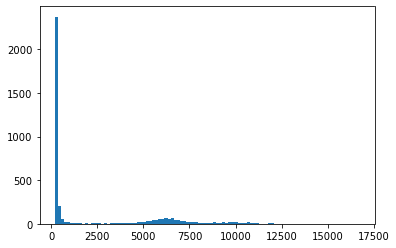

In [18]:
bcv = [x for b,x in barcode_hist.items() if x > 200 and x < 20000]
_ = plt.hist(bcv,bins=100)
print(len(bcv))

In [19]:
bad_barcode = [x for x in barcode_hist if  barcode_hist[x] <= 2000]
len(bad_barcode)/len(cell_gene)

0.9787994891443167

In [20]:
s = 0
bad_s = 0
bad_barcode_set = set(bad_barcode)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    cgs =  sum(cg[g] for g in cg)
    s += cgs
    if barcode in bad_barcode_set:
        bad_s += cgs
    

In [21]:
bad_s/s

0.09757645370484552

In [22]:
outfile = './kallisto_pbmc1kv3_out/matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 2000 and x < 10000]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])



In [23]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))
    

In [29]:
gene_names = {}
with open('../index/mart_export_human.txt') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


FileNotFoundError: [Errno 2] No such file or directory: '../index/mart_export_human.txt'

In [14]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('./kallisto_pbmc1kv3_out/genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('./kallisto_pbmc1kv3_out/barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')

In [15]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './kallisto_pbmc1kv3_out/pbmc1k.h5ad'
sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx('./kallisto_pbmc1kv3_out/', var_names='gene_symbols', cache=False)
adata.var_names_make_unique()

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [16]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

filtered out 20696 genes that are detected in less than 2 cells


In [17]:
adata = adata[adata.obs['n_genes'] < 5000, :]
adata = adata[adata.obs['percent_mito'] < 0.25, :]

In [18]:
adata

View of AnnData object with n_obs × n_vars = 1072 × 19599 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [19]:
sc.pp.log1p(adata)
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

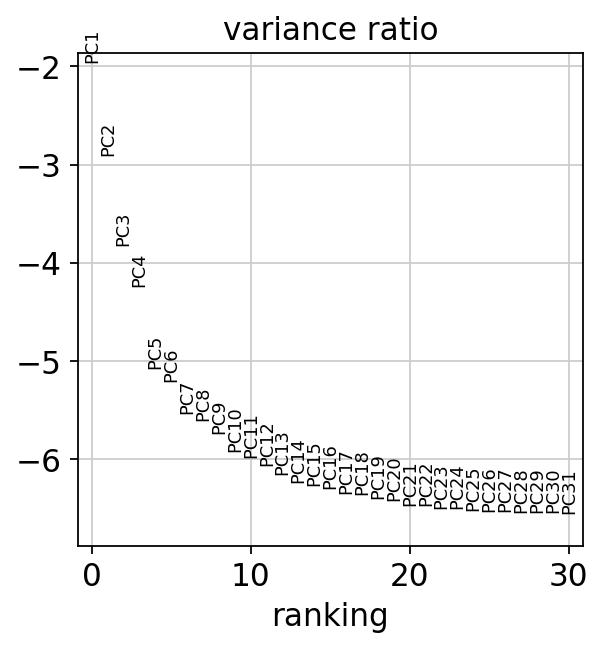

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:07.83) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:02.83) --> added
    'X_umap', UMAP coordinates (adata.obsm)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.04) --> found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


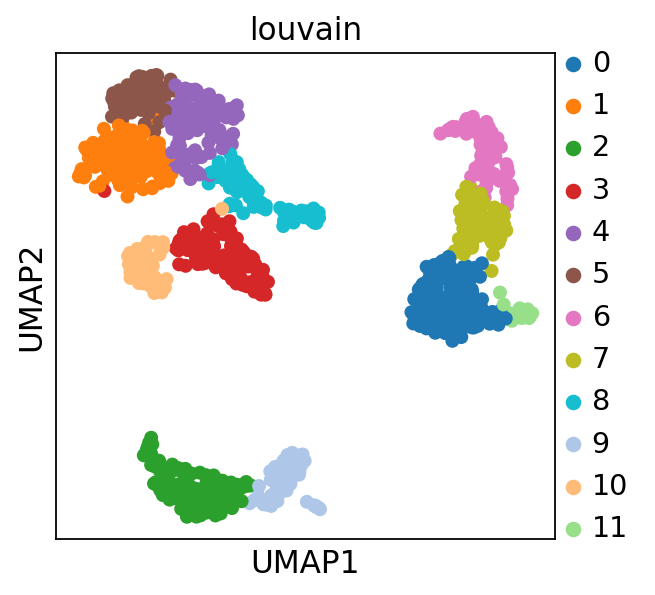

In [22]:
sc.tl.louvain(adata, resolution=1)
sc.pl.umap(adata, color=['louvain'])

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:27.54) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


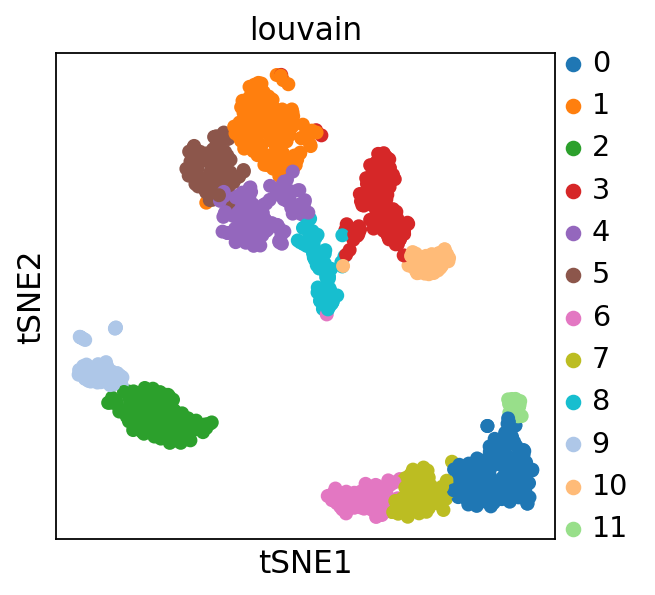

In [23]:
sc.tl.tsne(adata, n_pcs=20)
sc.pl.tsne(adata, color=['louvain'])

In [24]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test', corr_method='benjamini-hochberg')

ranking genes
    finished (0:00:01.43) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [25]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
#pd.DataFrame({group + '_' + key: result[key][group]
#    for group in groups for key in ['names', 'scores','logfoldchanges','pvals','pvals_adj']}).head(20)


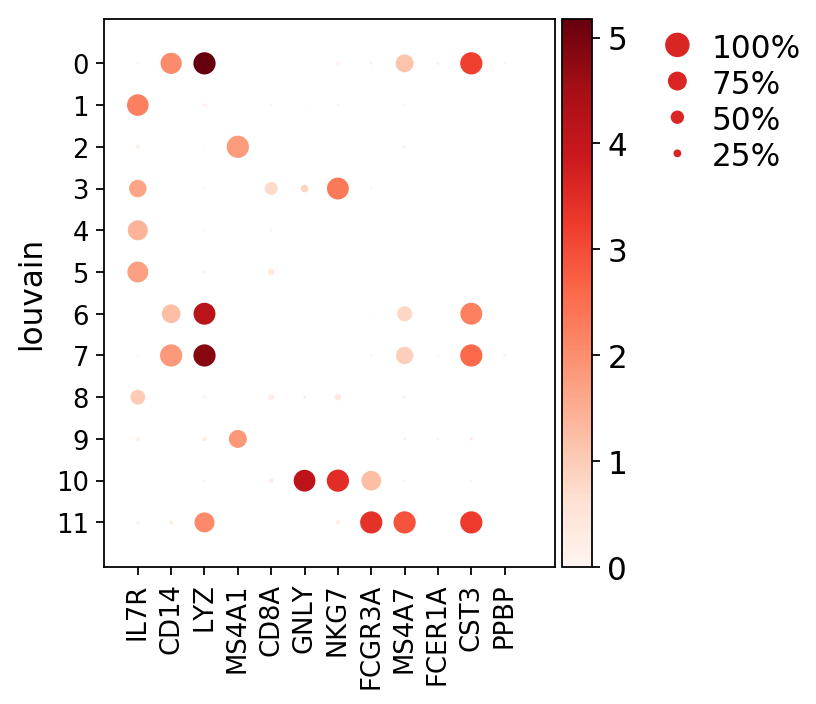

In [26]:
marker_genes = ['IL7R','CD14','LYZ','MS4A1','CD8A','GNLY','NKG7','FCGR3A','MS4A7','FCER1A','CST3','PPBP']
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

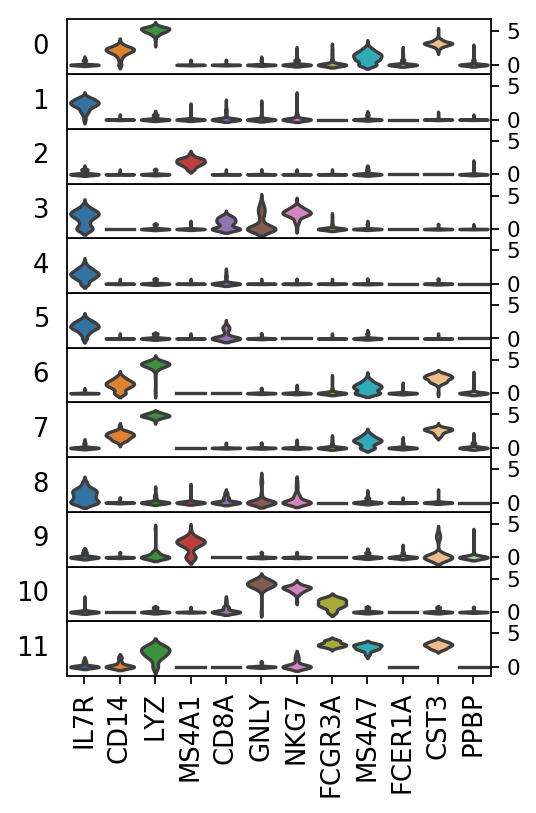

In [27]:
sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)